In [190]:
import os,sys, importlib, numpy as np
import matplotlib.pyplot as plt
import jpcm
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [191]:
# user=os.popen('whoami').read().replace('\n','')
user='mitt-wsl'
print(f'User: {user}')
model = "TF/control/WV_0_PC_0_EH_0_PS_1_6"

spec = importlib.util.spec_from_file_location("module.name", f'./user/{user}_param.py')
userparam = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = userparam
spec.loader.exec_module(userparam)

checkpoint_dir = userparam.param['model_dir']

result_path = f"{checkpoint_dir}/{model}/test_result/"

User: mitt-wsl


In [192]:
gt = np.load(f'{result_path}true_data.npy'.replace('/mnt/c','C:'))
pd = np.load(f'{result_path}pred_data.npy'.replace('/mnt/c','C:'))

In [193]:
print(gt.shape)
print(pd.shape)

(17, 3, 40, 1, 64, 64)
(17, 3, 40, 1, 64, 64)


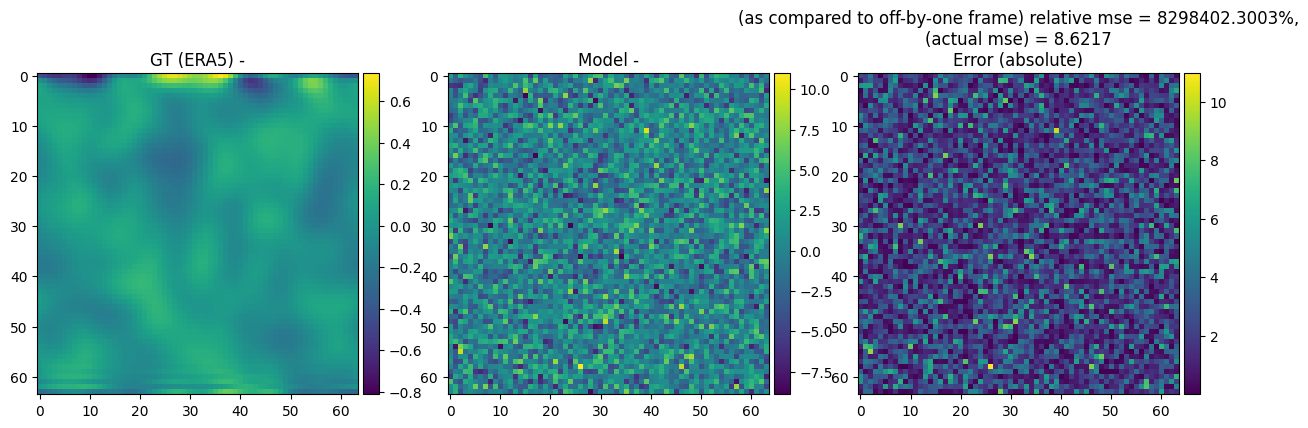

In [197]:
# stepi = 5
# var_dicts = {0:'u wind', 1:'v wind', 2:'Sea Surface Temperature',
#             3:'Surface Pressure', 4:'Precipitation'}
var_dicts = {0:'-',}
shift = gt.shape[2] - pd.shape[2]
var = 0
b = 0 # BATCH
a = 0 # MINIBATCH
stepi = 35

fig, axs = plt.subplots(1,3, figsize=(15,10))
ax0 = axs[0]
im0 = ax0.imshow(gt[b,a,shift+stepi,var,:,:])
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
ax0.set_title('GT (ERA5) '+var_dicts[var])

ax1 = axs[1]
im1 = ax1.imshow(pd[b,a,stepi,var,:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('Model '+var_dicts[var])

ax2 = axs[2]
d = gt[b,a,shift+stepi,var,:,:]-pd[b,a,stepi,var,:,:]
d0 = gt[b,a,shift+stepi+1,var,:,:]-gt[b,a,shift+stepi,var,:,:]
im2 = ax2.imshow(np.abs(d))
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
mse = np.mean(d**2)
meanMse = mse*100 / np.mean(d0**2)
# medianMse = np.median(d**2)*100 / np.median(d0**2)
ax2.set_title(f'(as compared to off-by-one frame) relative mse = {meanMse:.4f}%,\n(actual mse) = {mse:.4f}\nError (absolute)')
plt.show()

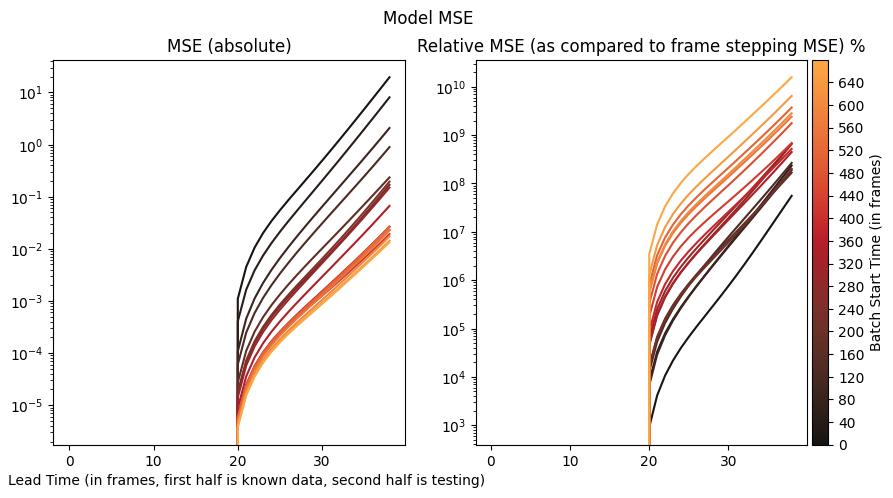

In [195]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
cmap = jpcm.get('desert')
cs = cmap.resampled(gt.shape[0]).colors
for b in range(gt.shape[0]): # for each batch (i.e. each general section of time)
    means = []
    relMeans = []
    for f in range(gt.shape[2]-shift-1): # for each frame (i.e. each time step in the batch)
        meanMse = 0
        meanShiftMse = 0
        for a in range(gt.shape[1]):
            d = gt[b,a,shift+f,var,:,:]-pd[b,a,f,var,:,:]
            d0 = gt[b,a,shift+f+1,var,:,:]-gt[b,a,shift+f,var,:,:]
            meanMse += np.mean(d**2)
            meanShiftMse += np.mean(d0**2)
        means.append(meanMse/gt.shape[1]) # average over minibatch
        relMeans.append(100*meanMse/meanShiftMse) # average over minibatch

    axs[0].plot(means, color=cs[b], label=f'Batch {b}')
    axs[1].plot(relMeans, color=cs[b], label=f'Batch {b}')
# plt.plot(medians, label='Median')
axs[0].set_xlabel('        Lead Time (in frames, first half is known data, second half is testing)')
axs[0].set_title('MSE (absolute)')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Relative MSE (as compared to frame stepping MSE) %')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(0, gt.shape[0] * gt.shape[2]), cmap=cmap
    ),
    cax=cax,
    orientation='vertical',
    label='Batch Start Time (in frames)',
    ticks=np.arange(0, gt.shape[0] * gt.shape[2], gt.shape[2]).tolist(),
)
# plt.legend()
plt.suptitle('Model MSE')
plt.show()

In [187]:
ss = np.std(pd[b,a,20:,var,:,:]-pd[b,a,19:-1,var,:,:] ,axis=(1,2)) **2   

In [188]:
ss

array([  1.97428235e-05,   2.08119527e-05,   2.61852201e-05,
         3.69766822e-05,   5.55165352e-05,   8.66274786e-05,
         1.40528107e-04,   2.36142179e-04,   4.07256914e-04,
         7.12758861e-04,   1.26551406e-03,   2.26860680e-03,
         4.10530390e-03,   7.47004803e-03,   1.37062930e-02,
         2.53937785e-02,   4.74776328e-02,   8.95182639e-02,
         1.70077577e-01,   3.25115979e-01], dtype=float32)

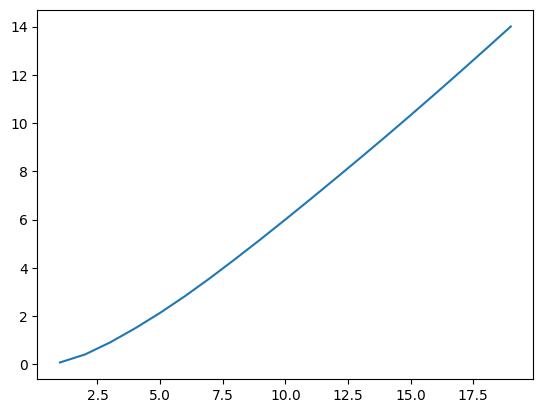

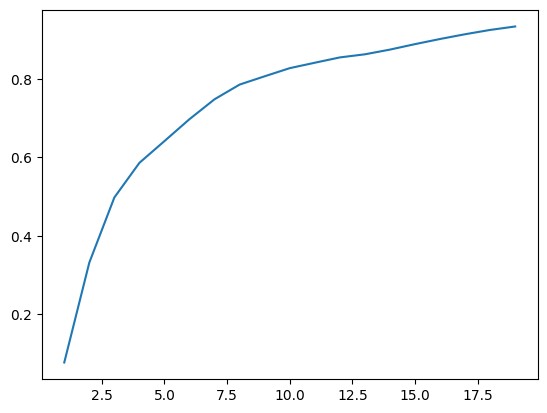

array([ 0.07608406,  0.3313403 ,  0.49786305,  0.58630174,  0.6419071 ,
        0.6979623 ,  0.7487972 ,  0.78628325,  0.8074746 ,  0.828238  ,
        0.842083  ,  0.8556824 ,  0.8636284 ,  0.87564945,  0.88963604,
        0.9027729 ,  0.91493416,  0.92593956,  0.93476105], dtype=float32)

In [189]:
d = np.log(ss/ss[0])/np.log(2)
plt.plot(np.arange(1,20),d[1:])
plt.show()
plt.plot(np.arange(1,20),d[1:]-d[:-1])
plt.show()
d[1:]-d[:-1]

In [125]:
ss = np.std(gt[b,a,:,var,:,:] ,axis=(1,2)) 

In [120]:
np.log(ss[-1]/ss[0])

-0.014395418